# Magnetic field produced by prisms

This code illustrates how to compute the magnetic field components produced by homogeneous rectangular prisms.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf
from gravmag import utils, data_structures

### Model

In [2]:
# Create a model formed by prisms
model = {
    'x1' : np.array([  2000.,  1600., -10000.,  -3000.]),
    'x2' : np.array([  3000.,  2600.,  10000.,  -2000.]),
    'y1' : np.array([ -1500., -2500.,   1500., -10000.]),
    'y2' : np.array([  -500., -1500.,   2500.,   1500.]),
    'z1' : np.array([    10.,    10.,     10.,     10.]),
    'z2' : np.array([  1010.,  1010.,   1010.,   1010.])
}

In [3]:
# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
h = 1
inc = -45
dec = 50
mx, my, mz = utils.magnetization_components(
    magnetization=np.array([[h, inc, dec]])
)

In [4]:
# arrays with the Cartesian magnetization components of each prism
mx = np.broadcast_to(array=mx, shape=(model['x1'].size,))
my = np.broadcast_to(array=my, shape=(model['x1'].size,))
mz = np.broadcast_to(array=mz, shape=(model['x1'].size,))

### Points were we compute the synthetic data

In [5]:
# number of points along x and y
shape = (100, 100)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# grid of computation points
coordinates_grid = data_structures.grid_xy(area=area, shape=shape, z0=-150)

In [6]:
# coordinates rearranged for plotting
# they are "views' of the original coordinates in 'coordinates_grid'
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x = coordinates_grid['x'],
    y = coordinates_grid['y'],
    shape = coordinates_grid['shape']
)

### Main field

In [7]:
# reference point
yc, xc = 0, 1000

# polynomial function defining the inclination (degrees)
I0 = 60 - 1e-5*(X-xc) + 3e-4*(Y-yc) + 1e-8*(X-xc)*(X-xc) + 1e-8*(Y-yc)*(Y-yc)

# polynomial function defining the declination (degrees)
D0 = 43 + 6e-5*(X-xc) + 1e-4*(Y-yc) + 3e-9*(X-xc)*(X-xc) + 4e-9*(Y-yc)*(Y-yc)

# polynomial function defining the intensity (nT)
F0 = 23400 + 1e-3*(X-xc) + 1e-3*(Y-yc) + 0*(X-xc)*(X-xc) + 0*(Y-yc)*(Y-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

# rearrange the computed field components and angle directions into 1d arrays
I0 = data_structures.grid_xy_full_matrix_to_flatten(grid = I0, ordering = 'xy')
D0 = data_structures.grid_xy_full_matrix_to_flatten(grid = D0, ordering = 'xy')
F0 = data_structures.grid_xy_full_matrix_to_flatten(grid = F0, ordering = 'xy')
Fx = data_structures.grid_xy_full_matrix_to_flatten(grid = Fx, ordering = 'xy')
Fy = data_structures.grid_xy_full_matrix_to_flatten(grid = Fy, ordering = 'xy')
Fz = data_structures.grid_xy_full_matrix_to_flatten(grid = Fz, ordering = 'xy')

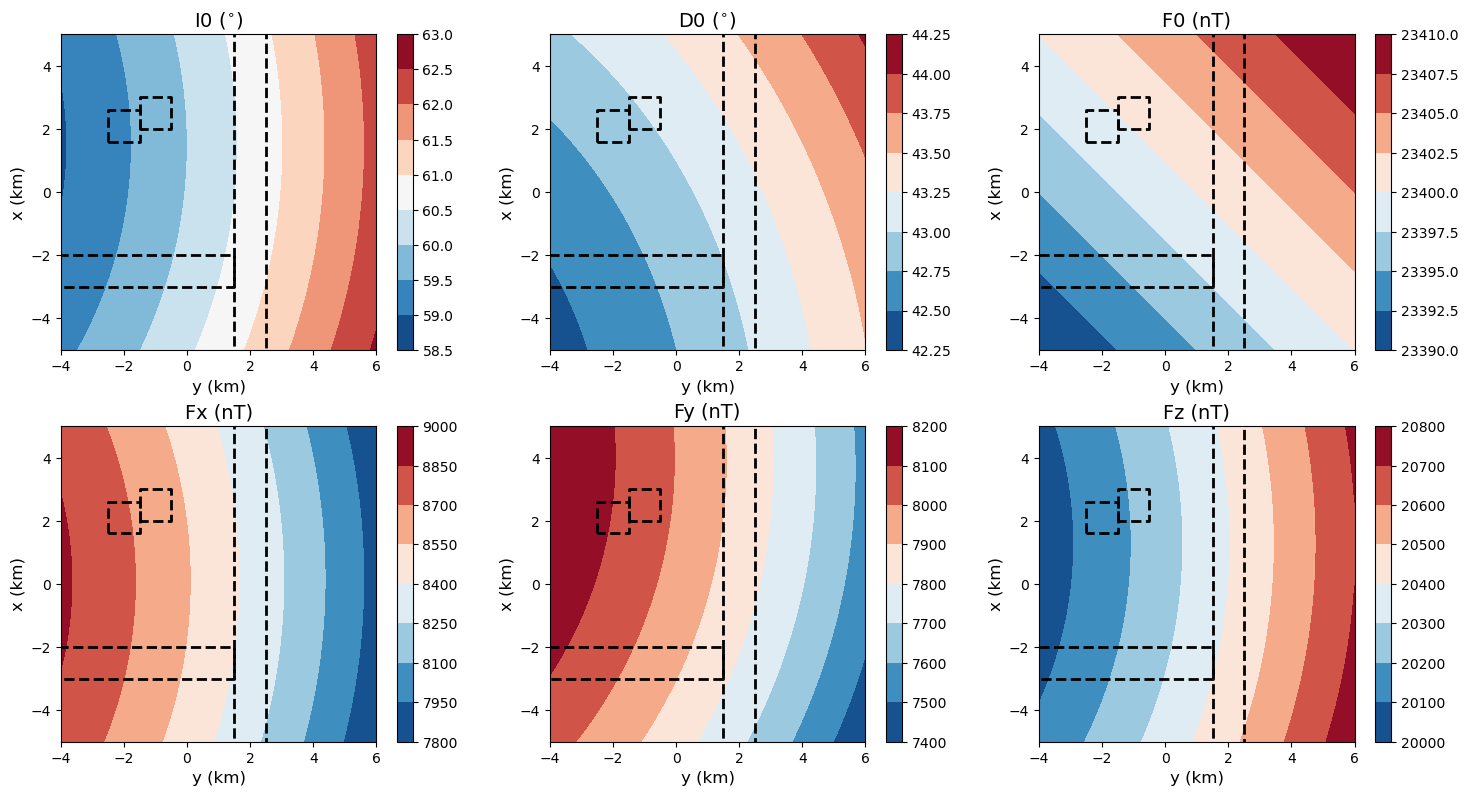

In [8]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r'
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Synthetic data

In [10]:
# Compute the scalar magnetic potential
V = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'potential'
)

# Compute the magnetic field components
bx = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'x'
)

by = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'y'
)

bz = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'z'
)

b_amp = np.sqrt(bx**2 + by**2 + bz**2)

# Compute the total-field anomaly
tfa = np.sqrt((Fx + bx)**2 + (Fy + by)**2 + (Fz + bz)**2) - F0

# Compute the approximated total-field anomaly (Blakely, 1996, p. 179)
# by using the average main geomagnetic field on the simulated area
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0

approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

### Plot the data

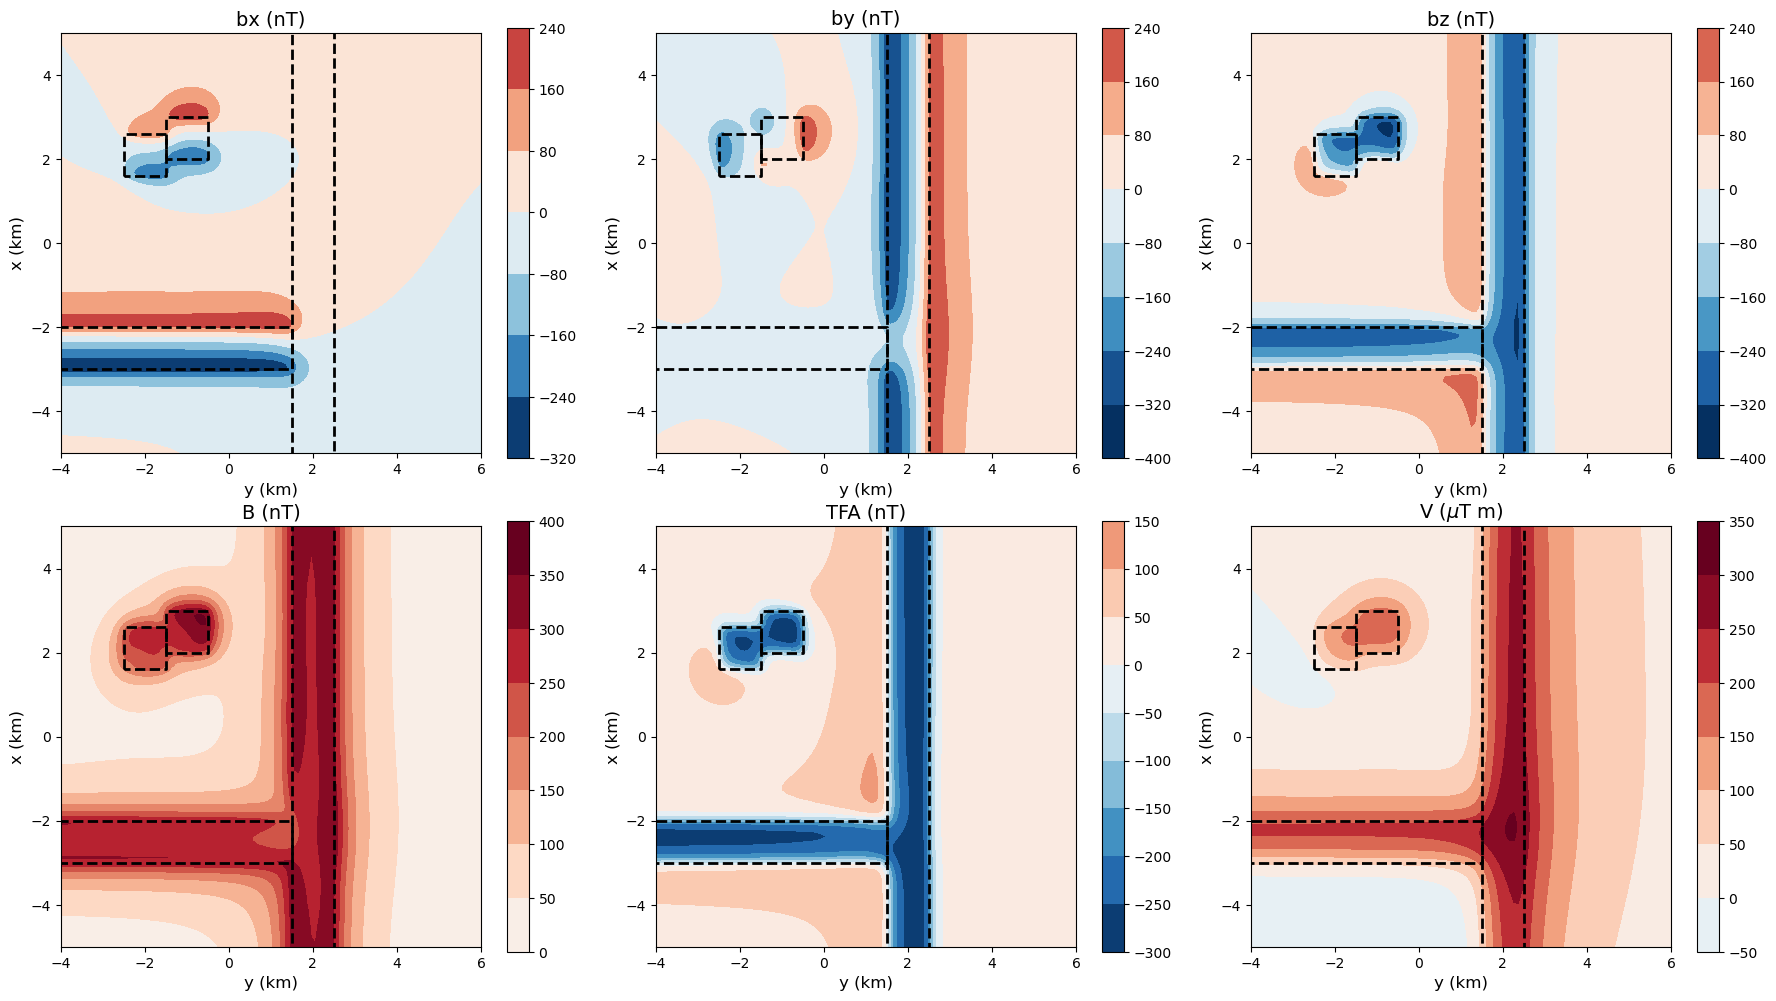

In [12]:
fields = [bx, by, bz, b_amp, tfa, V]
windows = [1, 2, 3, 4, 5, 6]
titles = ['bx (nT)', 'by (nT)', 'bz (nT)', 
          'B (nT)', 'TFA (nT)', 'V ($\mu$T m)']

plt.figure(figsize=(18,10))

for w, window in enumerate(windows):
    bounds = np.max(np.abs(fields[w]))
    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r', vmin=-bounds, vmax=bounds)
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()

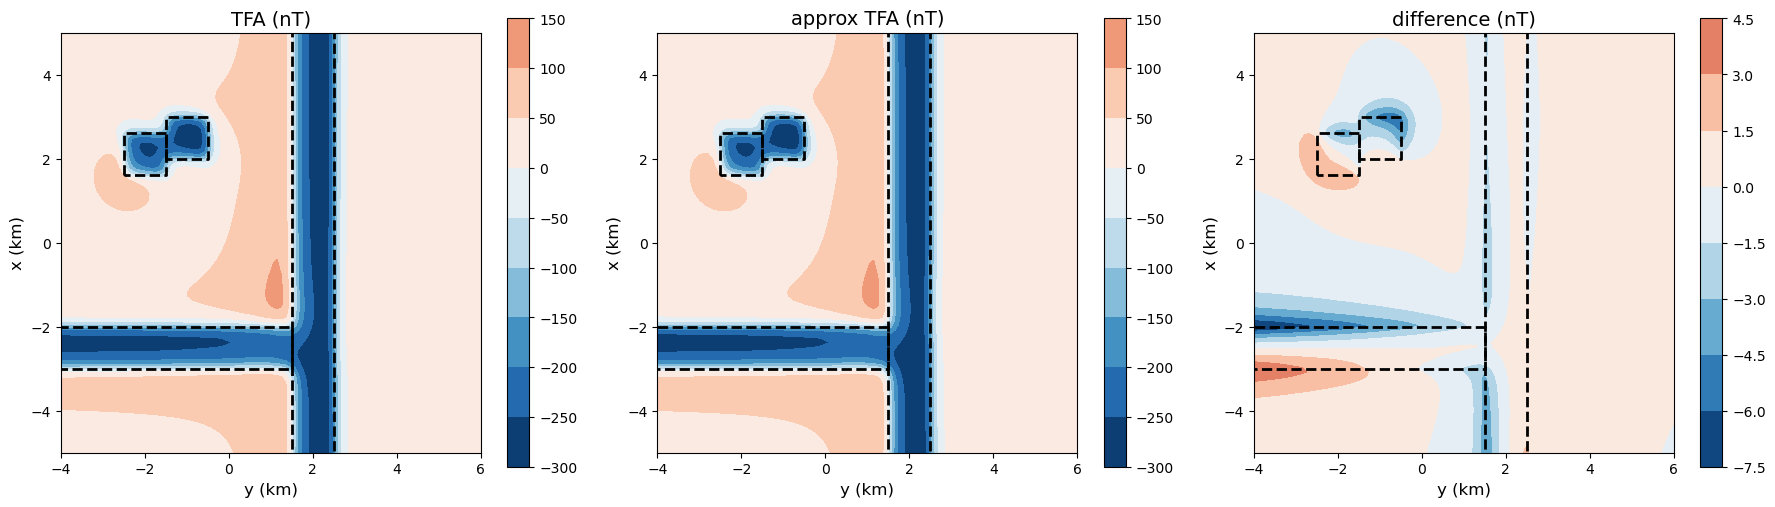

In [13]:
fields = [tfa, approx_tfa, diff_tfa]
windows = [1, 2, 3]
titles = ['TFA (nT)', 'approx TFA (nT)', 'difference (nT)']

plt.figure(figsize=(18,5))

for w, window in enumerate(windows):
    bounds = np.max(np.abs(fields[w]))
    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r', vmin=-bounds, vmax=bounds)
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()